In [139]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

In [3]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-11-25'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list, 
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%***********************]  503 of 503 completed


Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-11-28 A        40.981750   43.599998   44.689999   43.580002   44.520000   
           AAPL     25.831562   27.892500   28.117500   27.847500   27.857500   
           ABBV     42.172962   59.459999   59.939999   59.009998   59.130001   
           ABT      33.519840   38.740002   39.220001   38.700001   39.220001   
           ACGL     25.870779   27.206667   27.406668   27.116667   27.343332   
...                       ...         ...         ...         ...         ...   
2024-11-22 XYL     126.515785  126.870003  127.730003  125.760002  126.139999   
           YUM     134.617691  135.270004  135.869995  134.179993  134.529999   
           ZBH     110.220001  110.220001  110.370003  108.669998  108.669998   
           ZBRA    397.190002  397.190002  397.839996  392.540009  394.279999   
           ZTS     176.960007  176.960007  178.070007  176.279999  176.350006   

Price                   volume  
date       ticker               
2016-11-28 A         2241800.0  
           AAPL    108776000.0  
           ABBV      6274600.0  
           ABT       5727800.0  
           ACGL      1845000.0  
...                        ...  
2024-11-22 XYL       1365600.0  
           YUM        992500.0  
           ZBH       2015000.0  
           ZBRA       232000.0  
           ZTS       1854600.0  

[989262 rows x 6 columns]

## Calculate features and technical indicators for each stock.
##### Garman-Klass Volatlity
##### RSI
##### Bollinger Bands
##### ATR
##### MACD 
##### Dollar Volume

In [4]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
   atr = pandas_ta.atr(high=stock_data['high'],
                       low=stock_data['low'],
                       close=stock_data['close'],
                      length=14)
   return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
   macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
   return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-11-28 A        40.981750   43.599998   44.689999   43.580002   44.520000   
           AAPL     25.831562   27.892500   28.117500   27.847500   27.857500   
           ABBV     42.172962   59.459999   59.939999   59.009998   59.130001   
           ABT      33.519840   38.740002   39.220001   38.700001   39.220001   
           ACGL     25.870779   27.206667   27.406668   27.116667   27.343332   
...                       ...         ...         ...         ...         ...   
2024-11-22 XYL     126.515785  126.870003  127.730003  125.760002  126.139999   
           YUM     134.617691  135.270004  135.869995  134.179993  134.529999   
           ZBH     110.220001  110.220001  110.370003  108.669998  108.669998   
           ZBRA    397.190002  397.190002  397.839996  392.540009  394.279999   
           ZTS     176.960007  176.960007  178.070007  176.279999  176.350006   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-11-28 A         2241800.0         -0.002333        NaN       NaN   
           AAPL    108776000.0         -0.002156        NaN       NaN   
           ABBV      6274600.0         -0.043999        NaN       NaN   
           ABT       5727800.0         -0.009439        NaN       NaN   
           ACGL      1845000.0         -0.001127        NaN       NaN   
...                        ...               ...        ...       ...   
2024-11-22 XYL       1365600.0          0.000117  48.788613  4.778288   
           YUM        992500.0          0.000078  52.082158  4.878772   
           ZBH       2015000.0          0.000043  54.438181  4.658121   
           ZBRA       232000.0          0.000069  60.907590  5.914542   
           ZTS       1854600.0          0.000046  44.642241  5.147016   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-11-28 A            NaN       NaN       NaN       NaN      91.872888  
           AAPL         NaN       NaN       NaN       NaN    2809.853993  
           ABBV         NaN       NaN       NaN       NaN     264.618469  
           ABT          NaN       NaN       NaN       NaN     191.994941  
           ACGL         NaN       NaN       NaN       NaN      47.731587  
...                     ...       ...       ...       ...            ...  
2024-11-22 XYL     4.826566  4.874844  0.626261 -1.179897     172.769956  
           YUM     4.903059  4.927346  0.712395 -0.225595     133.608058  
           ZBH     4.699571  4.741022 -0.590623  0.465294     222.093302  
           ZBRA    5.964976  6.015410  0.087145  0.531073      92.148081  
           ZTS     5.180613  5.214210  0.660563 -1.215823     328.190028  

[989262 rows x 14 columns]

## Aggregate monthly levels and indicators to filter the top 150 most liquid stocks

In [5]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]

data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('ME').mean().stack('ticker').to_frame('dollar_volume'),
          df.unstack()[last_cols].resample('ME').last().stack('ticker')],
         axis=1).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2017-01-31 A          102.349484   46.162540         -0.000339  61.726290   
           AAPL      3120.691452   28.095907         -0.002159  71.538574   
           ABBV       344.889476   43.780563         -0.038072  49.986745   
           ABT        371.924577   36.375004         -0.004523  72.328504   
           ACGL        29.688113   28.003962         -0.001044  61.679154   
...                          ...         ...               ...        ...   
2024-11-30 XYL        203.028004  126.515785          0.000117  48.788613   
           YUM        268.905397  134.617691          0.000078  52.082158   
           ZBH        180.060551  110.220001          0.000043  54.438181   
           ZBRA       149.927101  397.190002          0.000069  60.907590   
           ZTS        528.385041  176.960007          0.000046  44.642241   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2017-01-31 A       3.803595  3.833158  3.862721 -1.381981  0.136707  
           AAPL    3.327728  3.356231  3.384733 -1.446601 -0.131992  
           ABBV    3.779777  3.810983  3.842188 -1.438255 -0.325409  
           ABT     3.557928  3.591215  3.624503 -1.412058  0.188883  
           ACGL    3.331300  3.355690  3.380080 -1.172477 -0.008442  
...                     ...       ...       ...       ...       ...  
2024-11-30 XYL     4.778288  4.826566  4.874844  0.626261 -1.179897  
           YUM     4.878772  4.903059  4.927346  0.712395 -0.225595  
           ZBH     4.658121  4.699571  4.741022 -0.590623  0.465294  
           ZBRA    5.914542  5.964976  6.015410  0.087145  0.531073  
           ZTS     5.147016  5.180613  5.214210  0.660563 -1.215823  

[46730 rows x 9 columns]

## Calculate 5-year rolling average of dollar volume for each stocks before filtering

In [6]:
data['dollar_volume'] = (data.loc[:,'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-12-31 AAPL     39.811531         -0.001775  47.784544  3.698682   
           ABBV     71.096031         -0.039988  55.000911  4.253741   
           ABT      50.525513         -0.006559  59.877771  3.884984   
           ACN     137.983627         -0.004850  65.003468  4.891671   
           ADBE    175.240005          0.000056  51.008416  5.137116   
...                       ...               ...        ...       ...   
2024-11-30 VZ       43.150002          0.000209  57.378871  3.713802   
           WFC      75.959999          0.000075  74.391808  4.137442   
           WMT      90.240067          0.000209  74.711050  4.392675   
           XOM     121.790001          0.000082  55.536678  4.760551   
           ZTS     176.960007          0.000046  44.642241  5.147016   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2017-12-31 AAPL    3.724109  3.749536 -1.257444 -0.269464  
           ABBV    4.278529  4.303317 -0.924108  0.077112  
           ABT     3.922018  3.959052 -1.373007  0.164545  
           ACN     4.921786  4.951901 -1.162140  0.224442  
           ADBE    5.167383  5.197650 -1.354089 -0.179053  
...                     ...       ...       ...       ...  
2024-11-30 VZ      3.747945  3.782089 -0.331598 -0.043189  
           WFC     4.260497  4.383553  1.816726  3.702242  
           WMT     4.445013  4.497350  2.702822  2.779545  
           XOM     4.791765  4.822979  0.427473  0.223347  
           ZTS     5.180613  5.214210  0.660563 -1.215823  

[12516 rows x 8 columns]

## Calculate Monthly returns for different time horizons as features

In [7]:
def calculate_returns(df):
    
    outlier_cutoff = 0.005
    
    lags = [1, 2, 3, 6, 9, 12]
    
    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                    upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))

    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-12-31 AAPL     37.665611         -0.000835  37.072847  3.585046   
           ABBV     70.416016         -0.026539  57.957293  4.152361   
           ABT      65.209167         -0.003189  55.190181  4.111693   
           ACN     129.389084         -0.002485  36.633902  4.807611   
           ADBE    226.240005          0.000161  46.330419  5.329066   
...                       ...               ...        ...       ...   
2024-11-30 VRTX    450.970001          0.000155  41.136384  6.090617   
           VZ       43.150002          0.000209  57.378871  3.713802   
           WFC      75.959999          0.000075  74.391808  4.137442   
           WMT      90.240067          0.000209  74.711050  4.392675   
           XOM     121.790001          0.000082  55.536678  4.760551   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2018-12-31 AAPL    3.697134  3.809221 -0.672172 -1.246500  -0.116698   
           ABBV    4.223280  4.294199  0.748414 -0.103454  -0.022064   
           ABT     4.169437  4.227180  0.308224 -0.322309  -0.023227   
           ACN     4.940240  5.072869 -0.151647 -1.466668  -0.142900   
           ADBE    5.452557  5.576047 -0.042862 -0.755168  -0.098250   
...                     ...       ...       ...       ...        ...   
2024-11-30 VRTX    6.170690  6.250762  2.751680 -1.830256  -0.052544   
           VZ      3.747945  3.782089 -0.331598 -0.043189   0.024211   
           WFC     4.260497  4.383553  1.816726  3.702242   0.176797   
           WMT     4.445013  4.497350  2.702822  2.779545   0.103600   
           XOM     4.791765  4.822979  0.427473  0.223347   0.042901   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-12-31 AAPL    -0.132912  -0.101245  -0.025181  -0.005637   -0.004607  
           ABBV     0.088210  -0.004972   0.002641   0.000530   -0.000801  
           ABT      0.024292  -0.003340   0.030303   0.022655    0.021488  
           ACN     -0.054156  -0.057936  -0.022971  -0.007415   -0.005345  
           ADBE    -0.040535  -0.057180  -0.012388   0.005118    0.021515  
...                      ...        ...        ...        ...         ...  
2024-11-30 VRTX    -0.015286  -0.031155  -0.001606   0.007739    0.020186  
           VZ      -0.012169   0.016046   0.013284   0.013771    0.015363  
           WFC      0.162932   0.093240   0.042643   0.037496    0.047667  
           WMT      0.058301   0.054043   0.055049   0.050330    0.044398  
           XOM      0.019307   0.010765   0.007683   0.018958    0.016421  

[10372 rows x 14 columns]

### Download Fama-French Factors and Calculate rolling factor betas

In [8]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
               'famafrench',
               start="2010")[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()


In [9]:
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-12-31 AAPL   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.116698
           ABBV   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.022064
           ABT    -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.023227
           ACN    -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.142900
           ADBE   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.098250
...                   ...     ...     ...     ...     ...        ...
2024-10-31 VRTX   -0.0097 -0.0087  0.0089 -0.0140  0.0103   0.023437
           VZ     -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.047257
           WFC    -0.0097 -0.0087  0.0089 -0.0140  0.0103   0.149230
           WMT    -0.0097 -0.0087  0.0089 -0.0140  0.0103   0.014861
           XOM    -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.003754

[10230 rows x 6 columns]

#### Filter out stocks with less than 10 months of data

In [10]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

#### Calculate rolling factor betas

In [11]:
betas = (factor_data.groupby(level=1, 
                    group_keys=False)
.apply(lambda x: RollingOLS(endog=x['return_1m'],
                            exog=sm.add_constant(x.drop('return_1m', axis=1)),
                            window=min(24, x.shape[0]),
                            min_nobs=len(x.columns)+1)
.fit(params_only=True)
.params
.drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-12-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-10-31 VRTX    0.875565  0.561738 -0.138340  1.074647 -0.149229
           VZ      0.734853 -0.727650  0.404497  0.236659  0.079245
           WFC     0.938969 -0.274122  1.298547 -1.246690 -0.662804
           WMT     0.647141 -0.013019 -0.188277  1.055352  0.075126
           XOM     0.366523 -0.109621  0.369991  0.571946  0.339940

[10195 rows x 5 columns]

In [12]:
factors = ['Mkt-RF', 'SMB',  'HML', 'RMW', 'CMA']

data = data.join(betas.groupby('ticker').shift())

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10133 entries, (Timestamp('2018-12-31 00:00:00'), 'AAPL') to (Timestamp('2024-11-30 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10133 non-null  float64
 1   rsi               10133 non-null  float64
 2   bb_low            10133 non-null  float64
 3   bb_mid            10133 non-null  float64
 4   bb_high           10133 non-null  float64
 5   atr               10133 non-null  float64
 6   macd              10133 non-null  float64
 7   return_1m         10133 non-null  float64
 8   return_2m         10133 non-null  float64
 9   return_3m         10133 non-null  float64
 10  return_6m         10133 non-null  float64
 11  return_9m         10133 non-null  float64
 12  return_12m        10133 non-null  float64
 13  Mkt-RF            10133 non-null  float64
 14  SMB               10133 non-null  float64
 15  HML       

## Create K-means clustering to determine our portfolio

#### Create pre-defined centroids

In [13]:
from sklearn.cluster import KMeans

# data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init='random').fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-12-31 AAPL           -0.000835  37.072847  3.585046  3.697134  3.809221   
           ABBV           -0.026539  57.957293  4.152361  4.223280  4.294199   
           ABT            -0.003189  55.190181  4.111693  4.169437  4.227180   
           ACN            -0.002485  36.633902  4.807611  4.940240  5.072869   
           ADBE            0.000161  46.330419  5.329066  5.452557  5.576047   
...                             ...        ...       ...       ...       ...   
2024-11-30 VRTX            0.000155  41.136384  6.090617  6.170690  6.250762   
           VZ              0.000209  57.378871  3.713802  3.747945  3.782089   
           WFC             0.000075  74.391808  4.137442  4.260497  4.383553   
           WMT             0.000209  74.711050  4.392675  4.445013  4.497350   
           XOM             0.000082  55.536678  4.760551  4.791765  4.822979   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-12-31 AAPL   -0.672172 -1.246500  -0.116698  -0.132912  -0.101245   
           ABBV    0.748414 -0.103454  -0.022064   0.088210  -0.004972   
           ABT     0.308224 -0.322309  -0.023227   0.024292  -0.003340   
           ACN    -0.151647 -1.466668  -0.142900  -0.054156  -0.057936   
           ADBE   -0.042862 -0.755168  -0.098250  -0.040535  -0.057180   
...                     ...       ...        ...        ...        ...   
2024-11-30 VRTX    2.751680 -1.830256  -0.052544  -0.015286  -0.031155   
           VZ     -0.331598 -0.043189   0.024211  -0.012169   0.016046   
           WFC     1.816726  3.702242   0.176797   0.162932   0.093240   
           WMT     2.702822  2.779545   0.103600   0.058301   0.054043   
           XOM     0.427473  0.223347   0.042901   0.019307   0.010765   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-12-31 AAPL    -0.025181  -0.005637   -0.004607  1.295934 -0.242620   
           ABBV     0.002641   0.000530   -0.000801  0.532861  0.324160   
           ABT      0.030303   0.022655    0.021488  0.760747 -0.049255   
           ACN     -0.022971  -0.007415   -0.005345  1.205518 -0.205541   
           ADBE    -0.012388   0.005118    0.021515  1.313358 -0.561885   
...                      ...        ...         ...       ...       ...   
2024-11-30 VRTX    -0.001606   0.007739    0.020186  0.497437  0.049636   
           VZ       0.013284   0.013771    0.015363  0.469318 -0.482857   
           WFC      0.042643   0.037496    0.047667  1.118616 -0.099998   
           WMT      0.055049   0.050330    0.044398  0.636940 -0.338440   
           XOM      0.007683   0.018958    0.016421  1.013795  0.061769   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-12-31 AAPL   -0.628194  0.334858  0.500223        1  
           ABBV   -0.158058  0.413251  0.537523        0  
           ABT    -0.437458  0.169144  0.981046        0  
           ACN    -0.225971  0.351440  0.013449        1  
           ADBE   -0.255237  0.315773 -0.423941        2  
...                     ...       ...       ...      ...  
2024-11-30 VRTX   -0.771872  0.301048  0.797281        2  
           VZ      0.295901  0.136043  0.096860        0  
           WFC     1.573543 -0.692192 -0.965623        3  
           WMT    -0.363500  0.182730  0.622913        3  
           XOM     0.894621 -0.466598  0.371492        0  

[10133 rows x 19 columns]

In [14]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return 

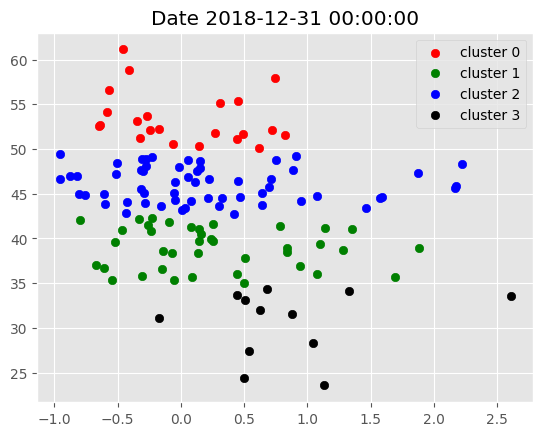

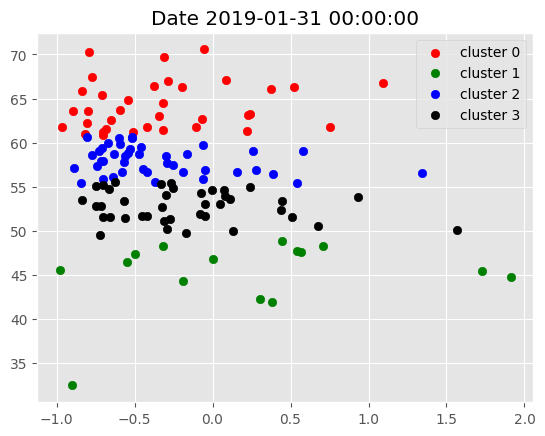

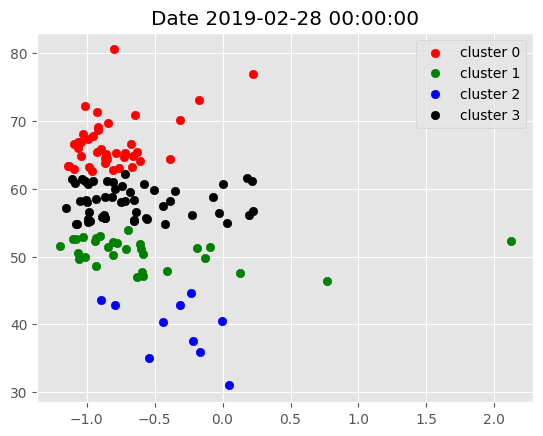

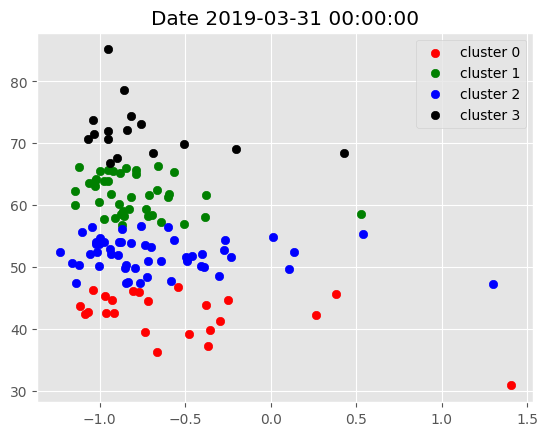

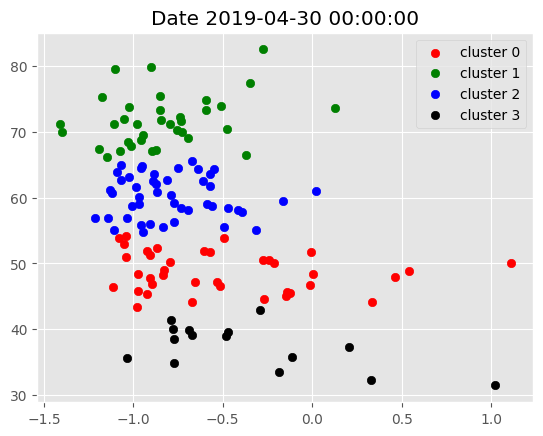

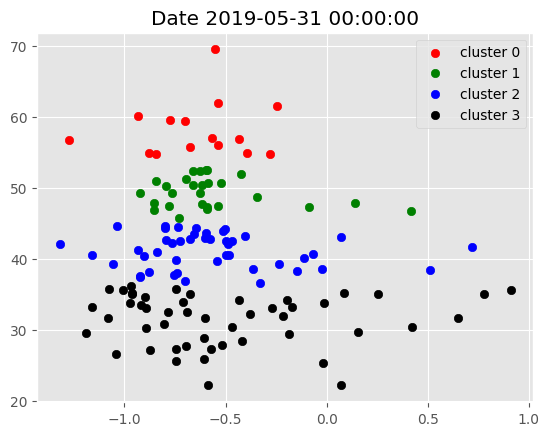

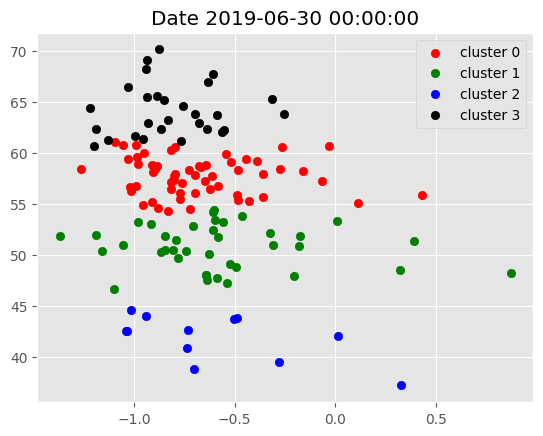

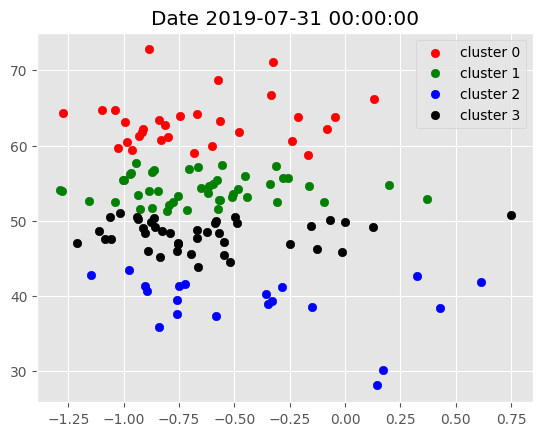

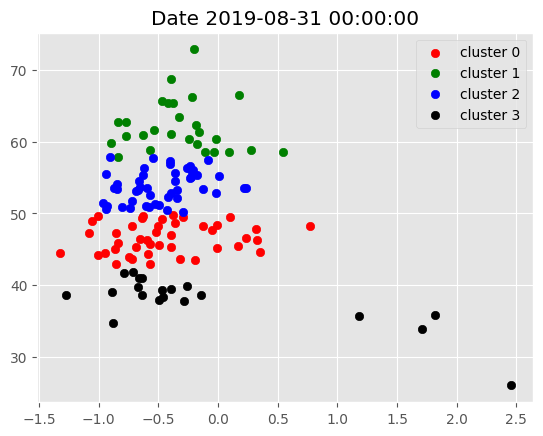

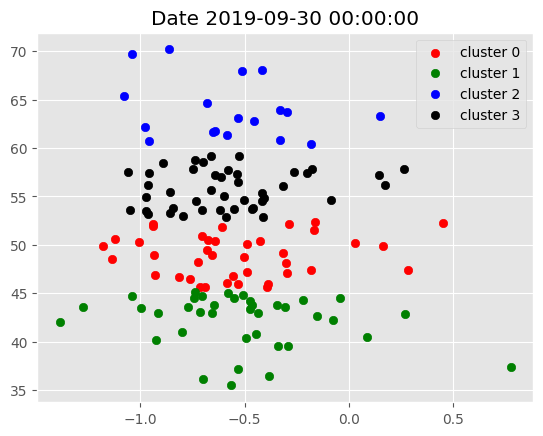

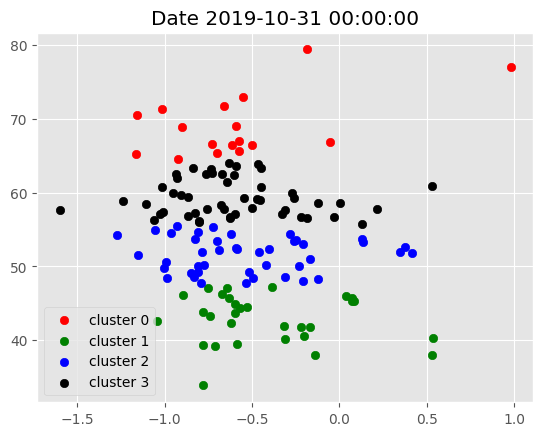

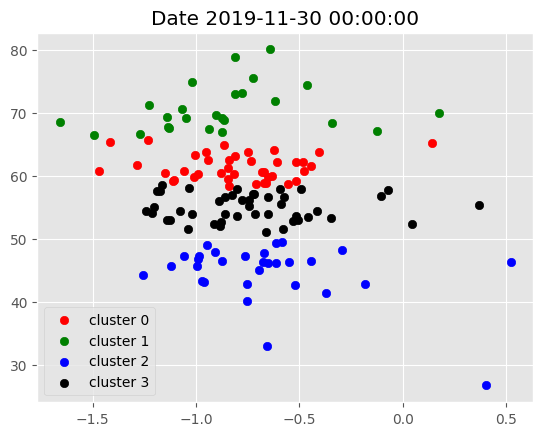

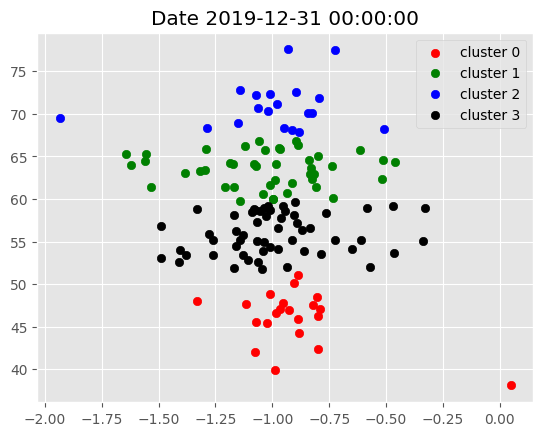

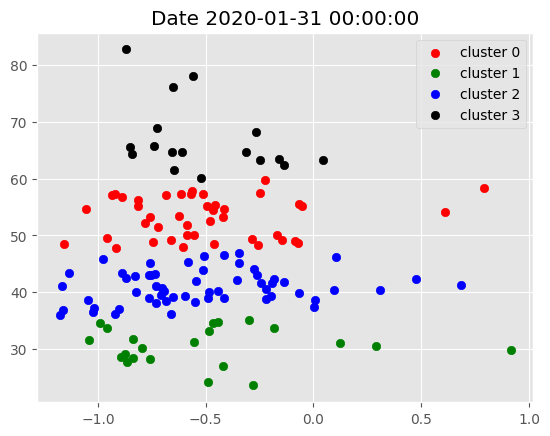

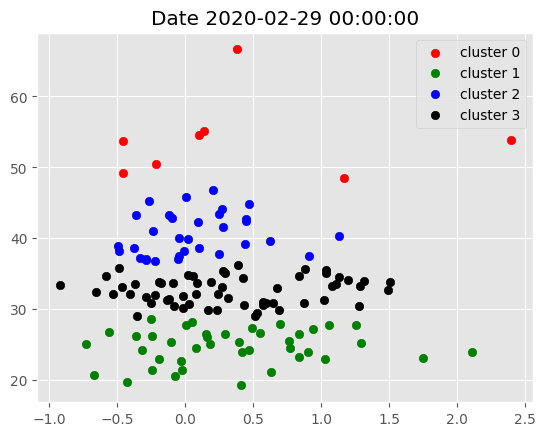

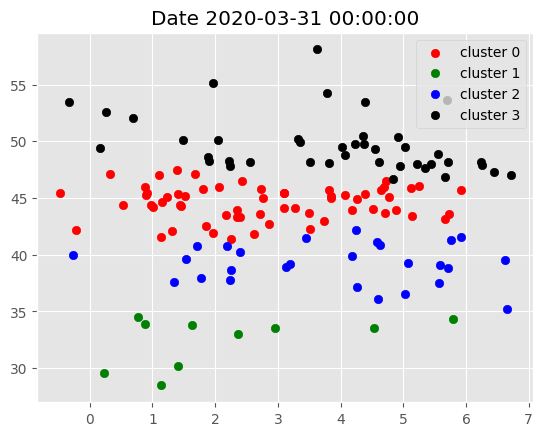

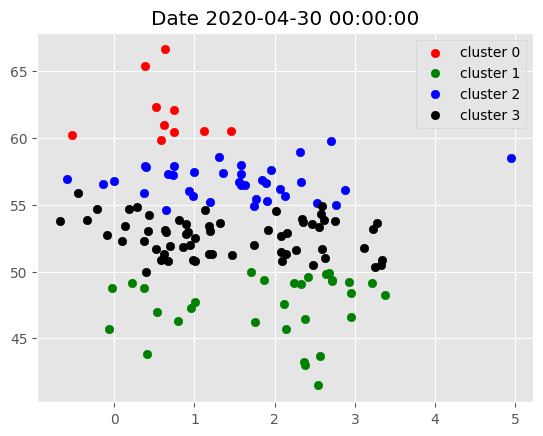

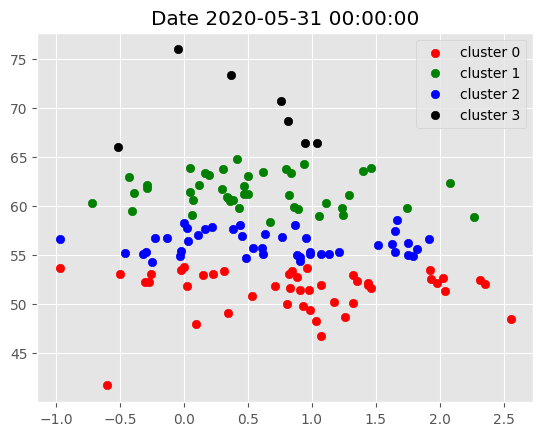

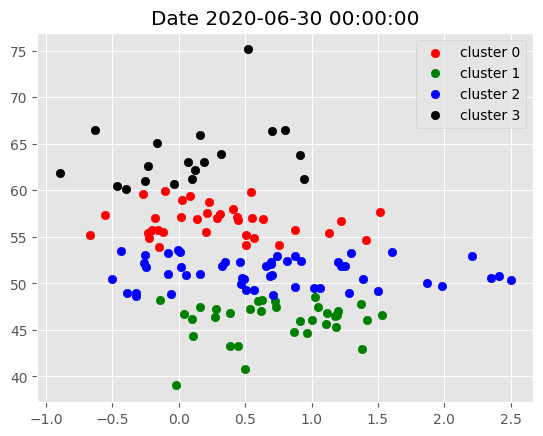

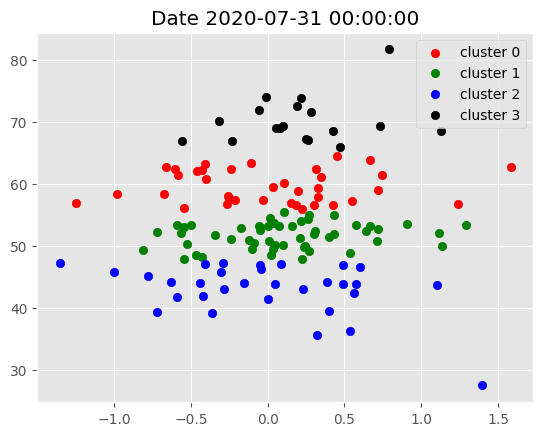

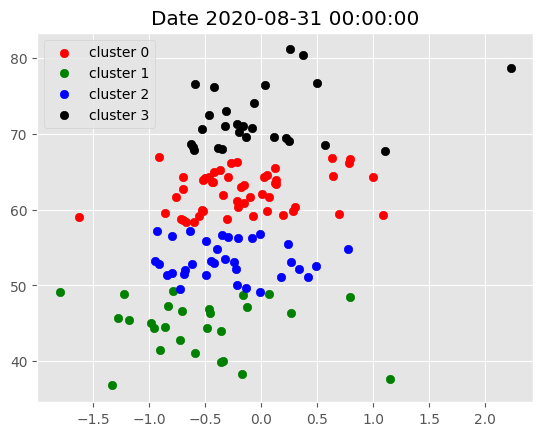

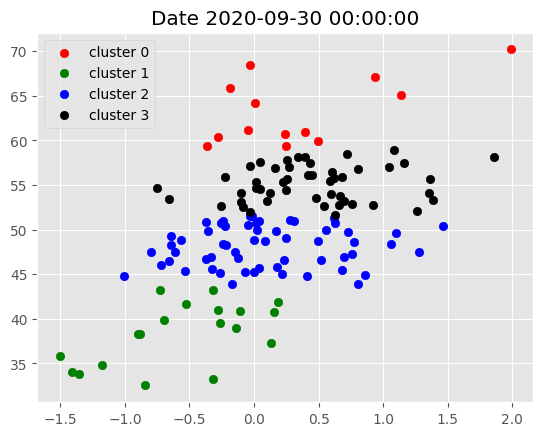

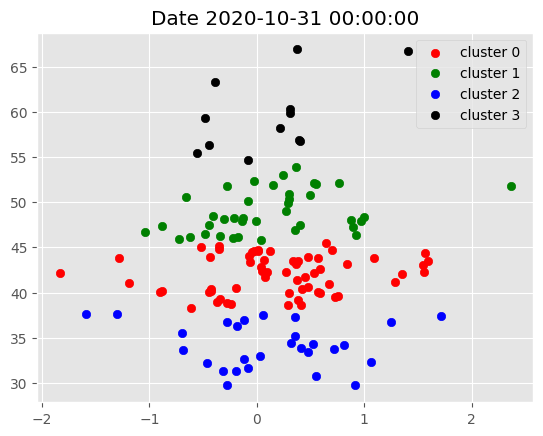

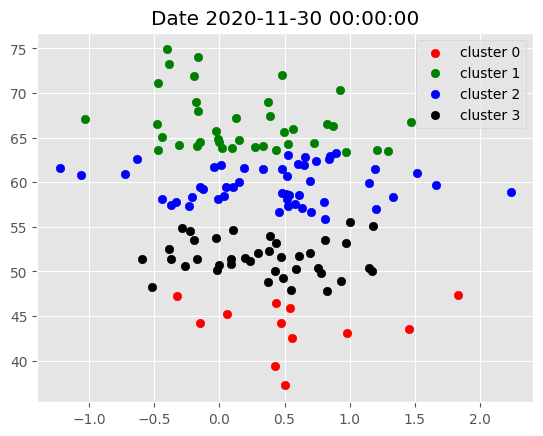

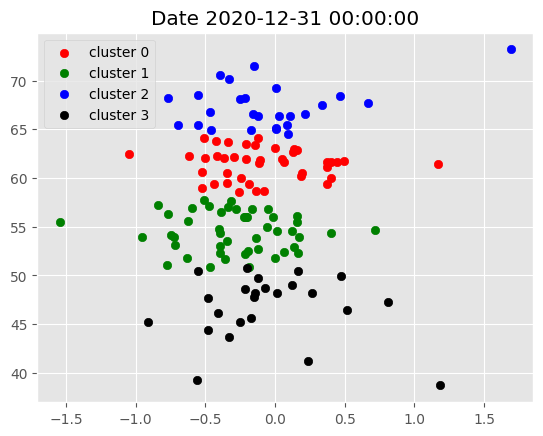

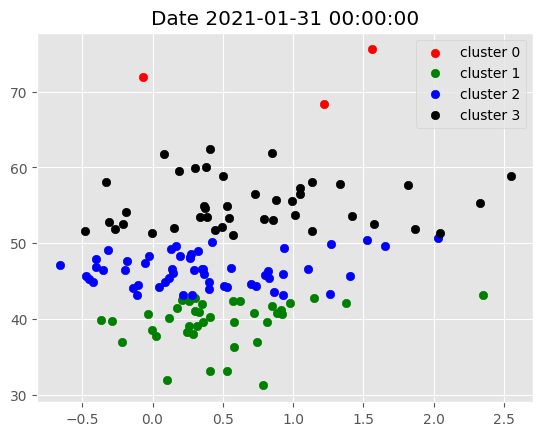

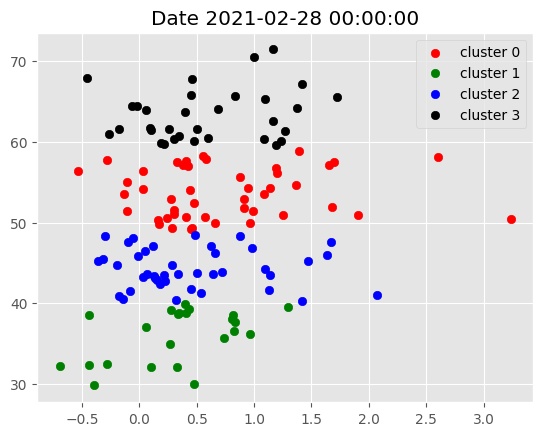

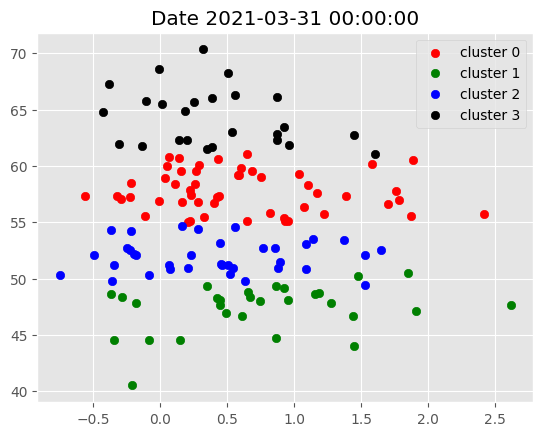

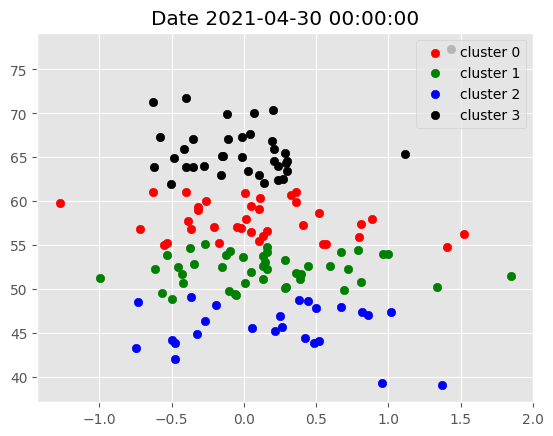

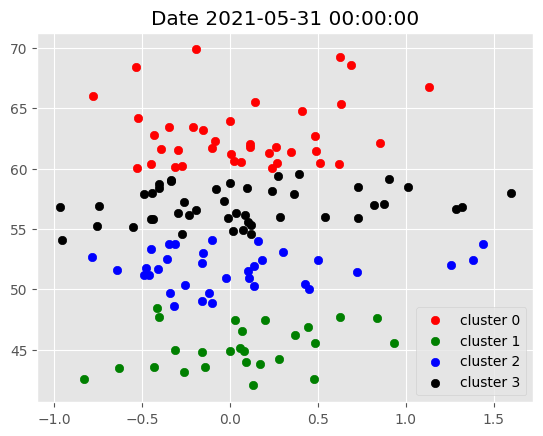

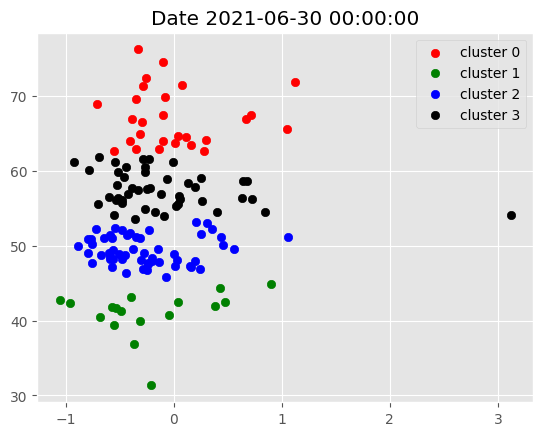

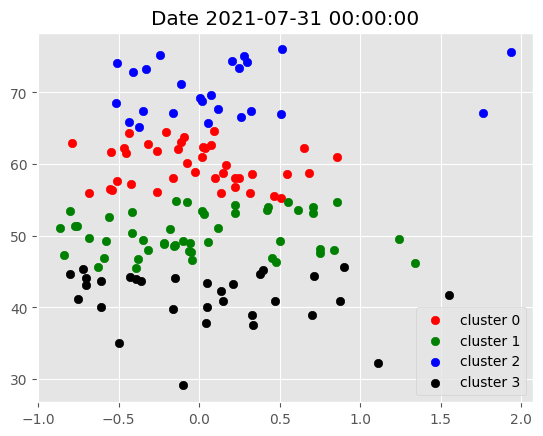

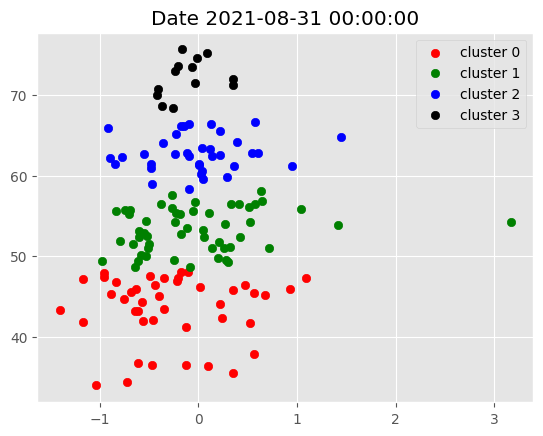

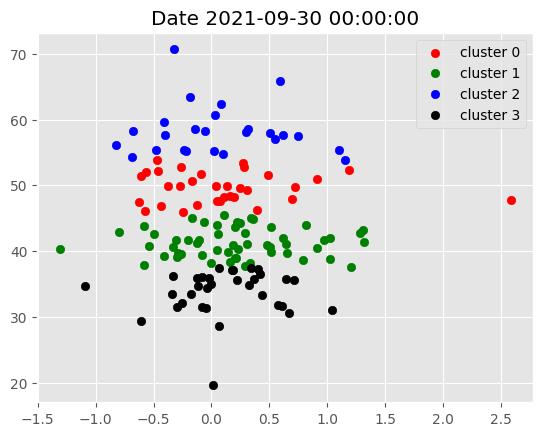

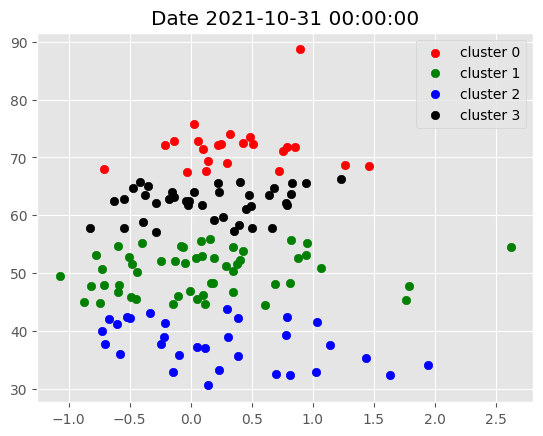

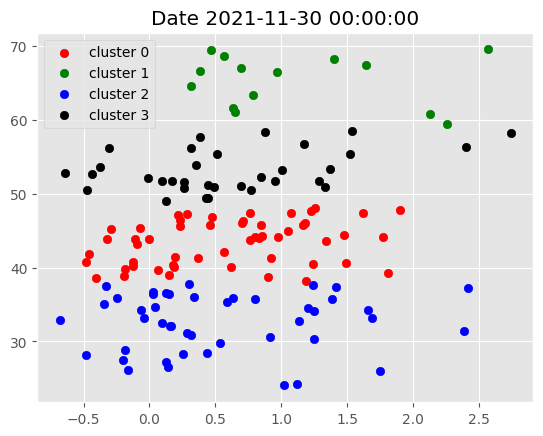

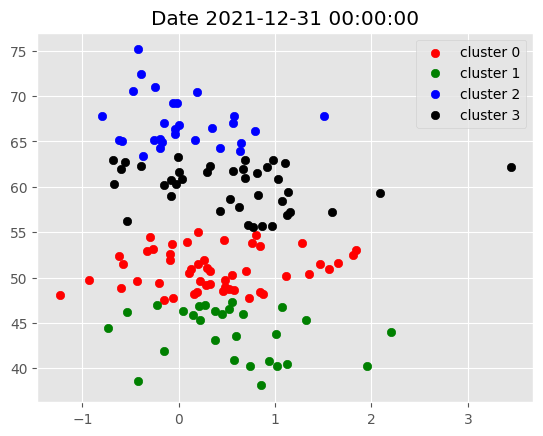

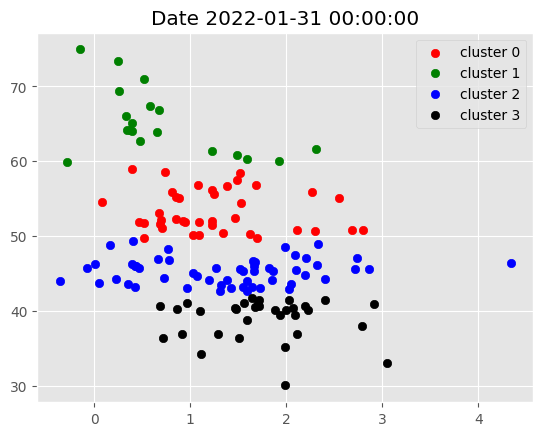

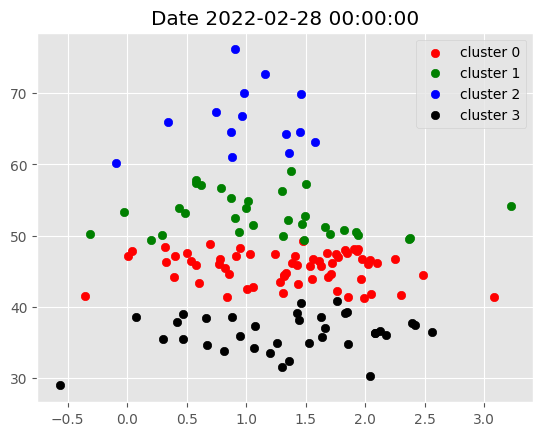

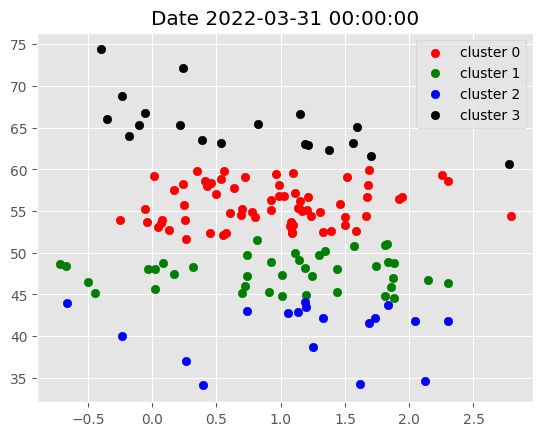

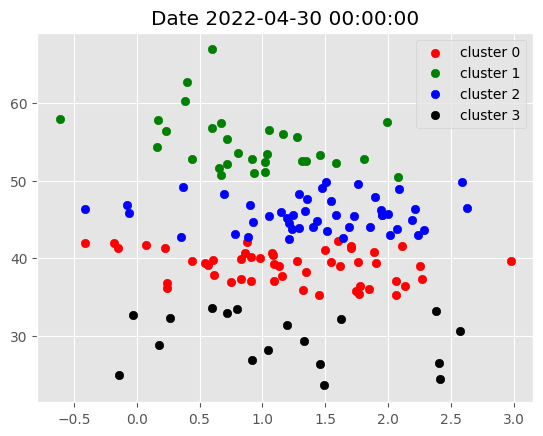

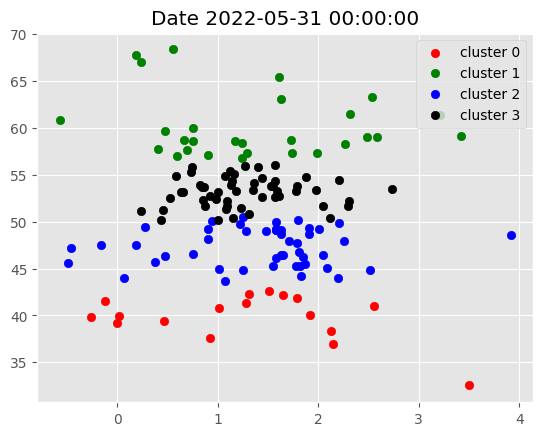

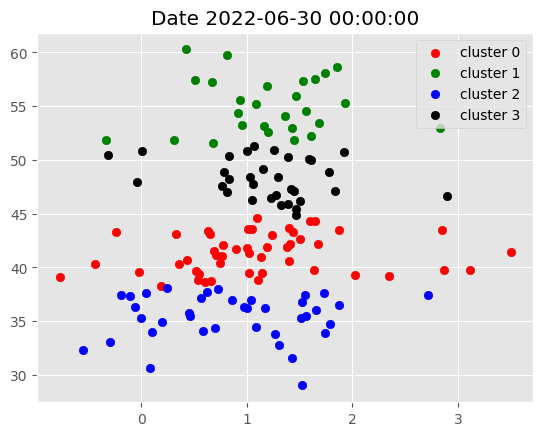

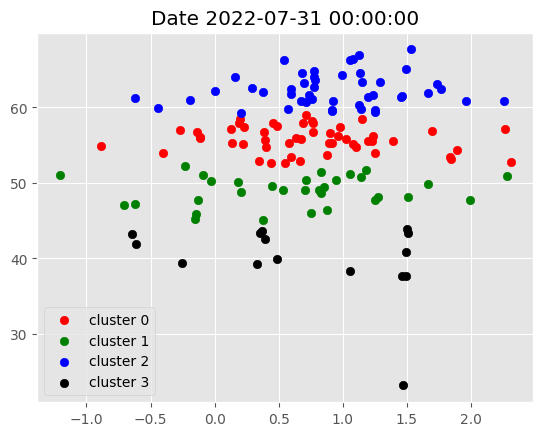

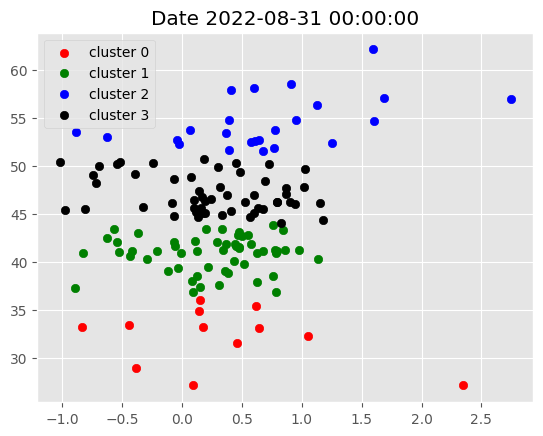

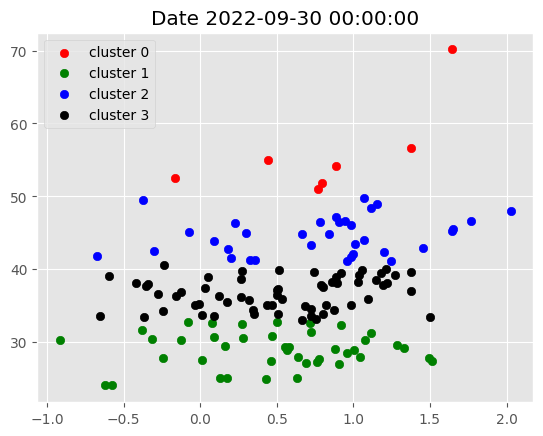

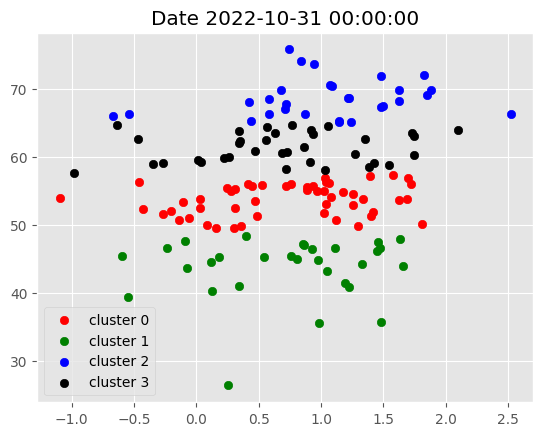

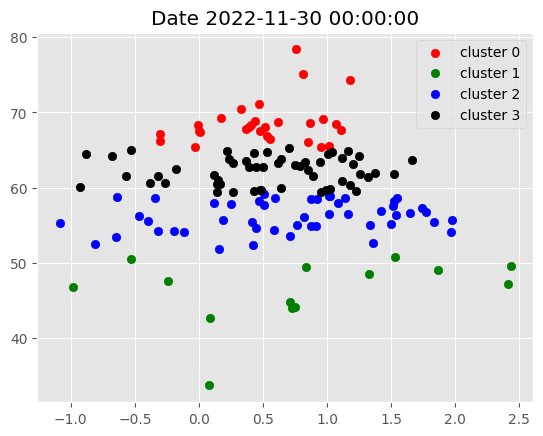

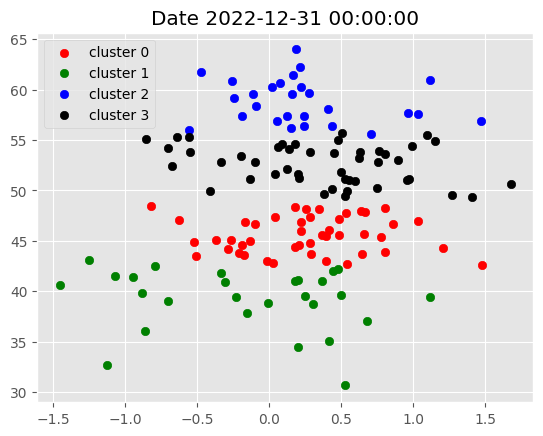

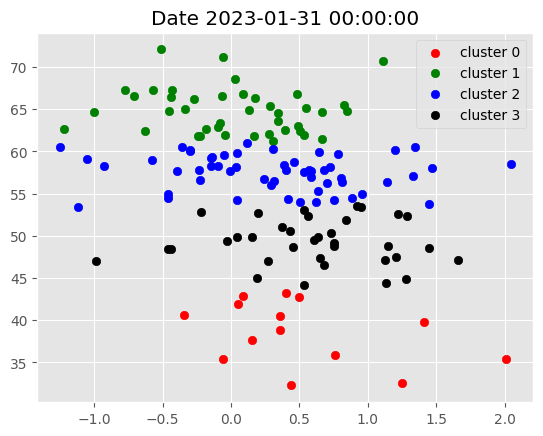

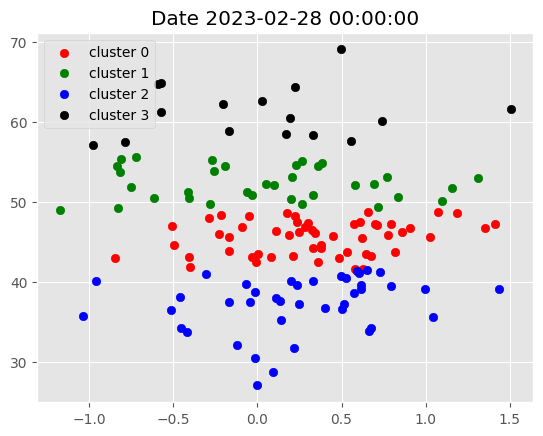

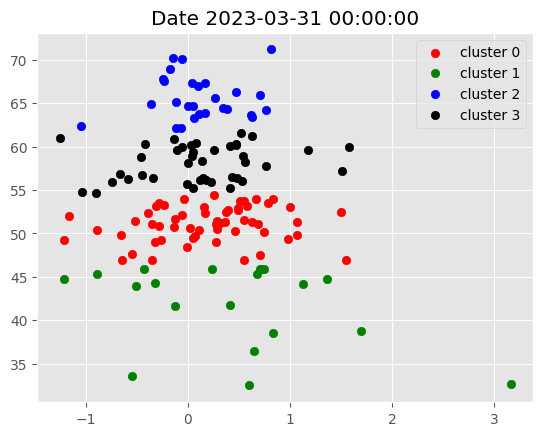

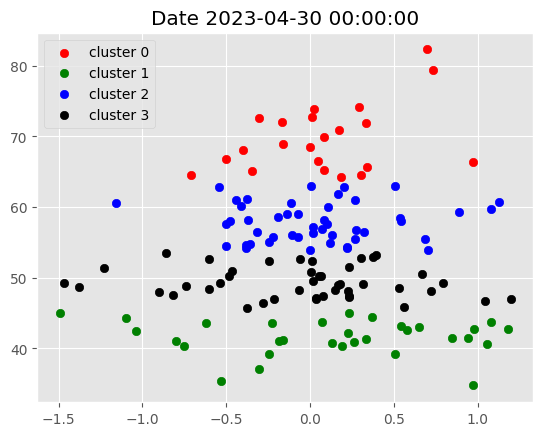

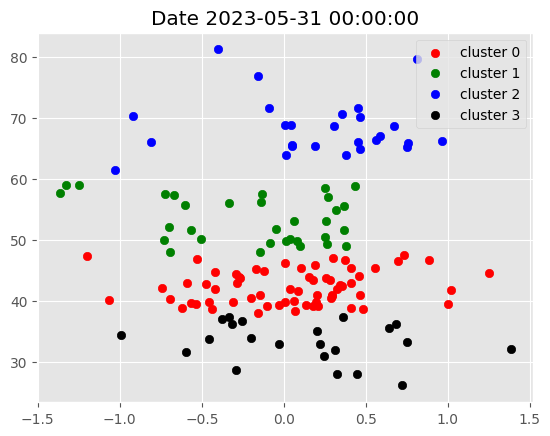

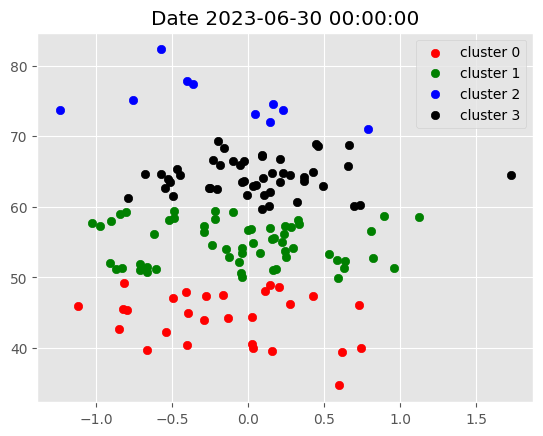

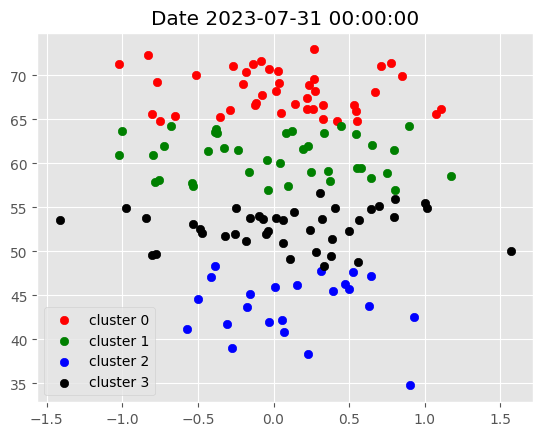

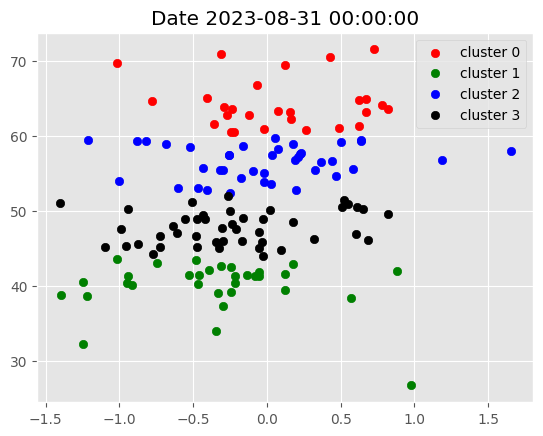

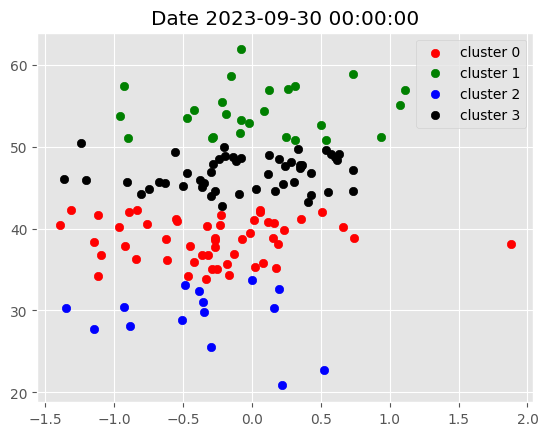

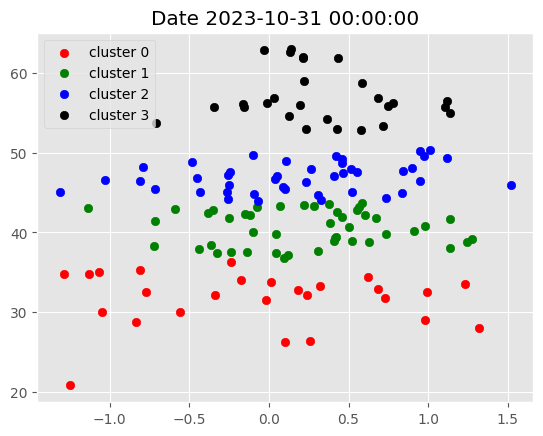

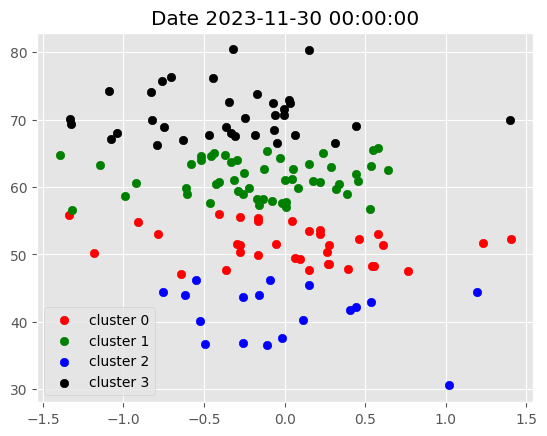

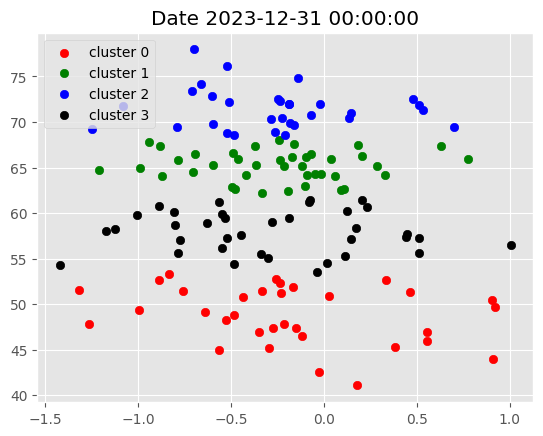

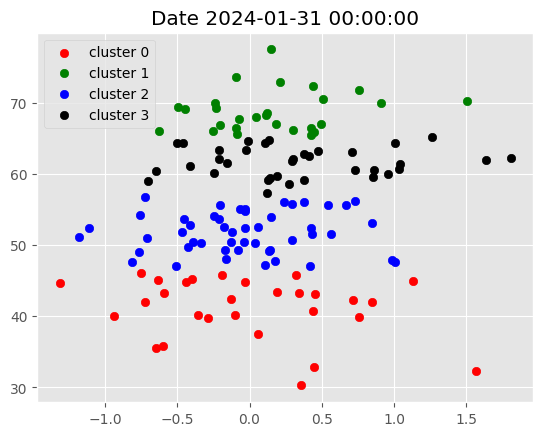

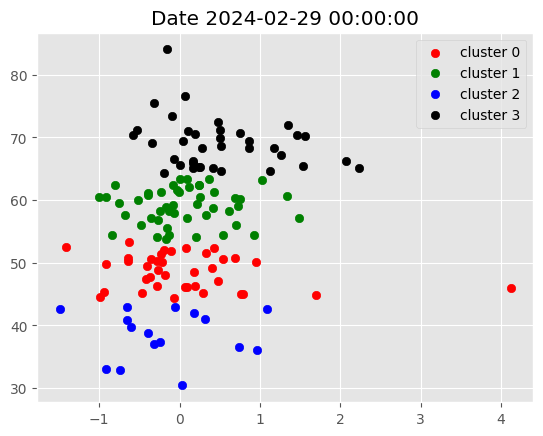

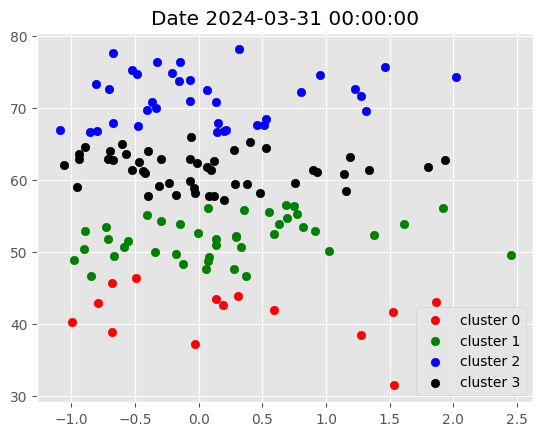

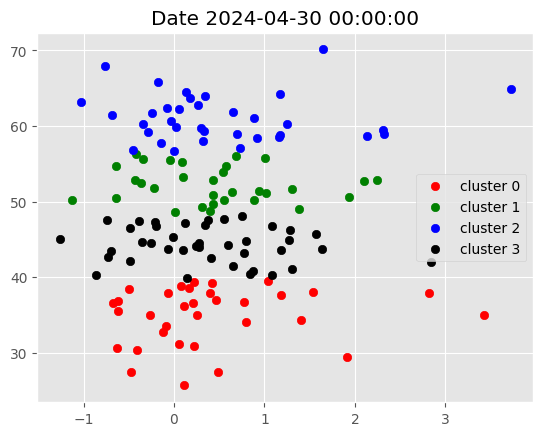

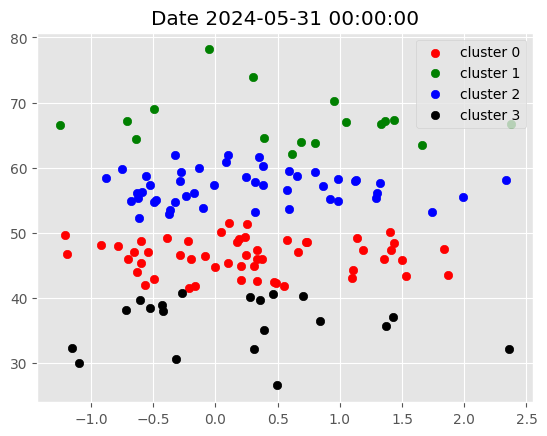

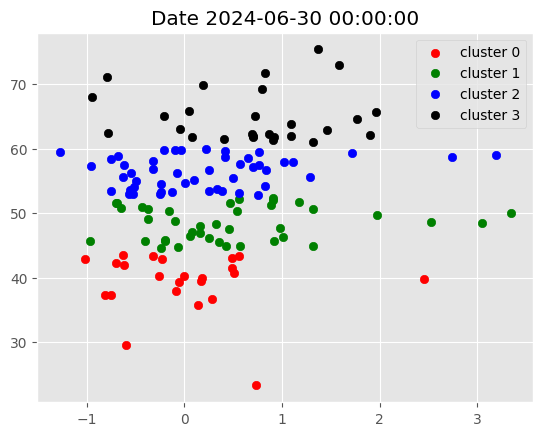

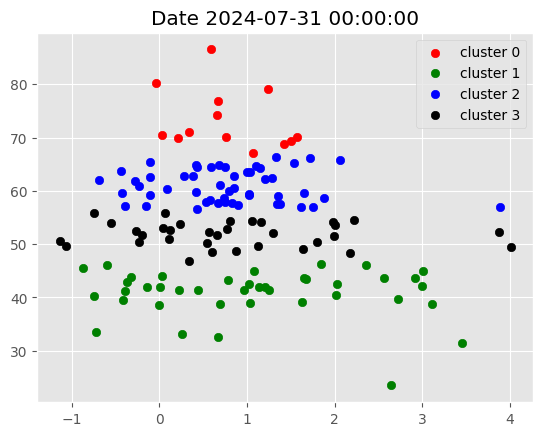

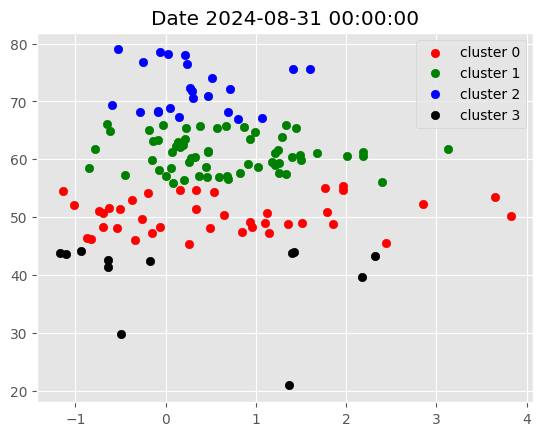

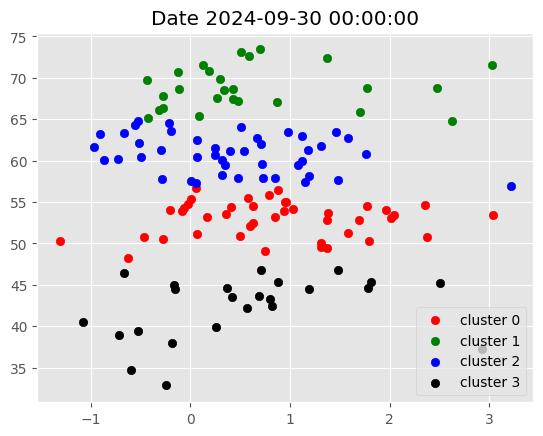

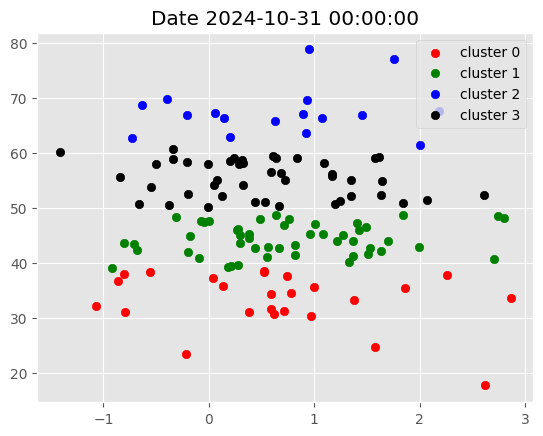

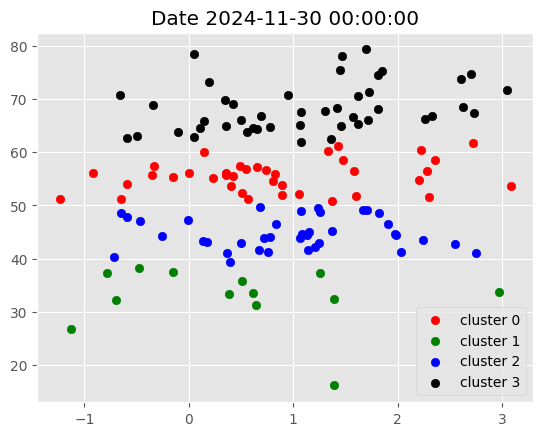

In [15]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')
    
    plot_clusters(g)

### Create pre defined centroids

In [16]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [17]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2018-12-31 AAPL           -0.000835  37.072847  3.585046  3.697134  3.809221   
           ABBV           -0.026539  57.957293  4.152361  4.223280  4.294199   
           ABT            -0.003189  55.190181  4.111693  4.169437  4.227180   
           ACN            -0.002485  36.633902  4.807611  4.940240  5.072869   
           ADBE            0.000161  46.330419  5.329066  5.452557  5.576047   
...                             ...        ...       ...       ...       ...   
2024-11-30 VRTX            0.000155  41.136384  6.090617  6.170690  6.250762   
           VZ              0.000209  57.378871  3.713802  3.747945  3.782089   
           WFC             0.000075  74.391808  4.137442  4.260497  4.383553   
           WMT             0.000209  74.711050  4.392675  4.445013  4.497350   
           XOM             0.000082  55.536678  4.760551  4.791765  4.822979   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2018-12-31 AAPL   -0.672172 -1.246500  -0.116698  -0.132912  -0.101245   
           ABBV    0.748414 -0.103454  -0.022064   0.088210  -0.004972   
           ABT     0.308224 -0.322309  -0.023227   0.024292  -0.003340   
           ACN    -0.151647 -1.466668  -0.142900  -0.054156  -0.057936   
           ADBE   -0.042862 -0.755168  -0.098250  -0.040535  -0.057180   
...                     ...       ...        ...        ...        ...   
2024-11-30 VRTX    2.751680 -1.830256  -0.052544  -0.015286  -0.031155   
           VZ     -0.331598 -0.043189   0.024211  -0.012169   0.016046   
           WFC     1.816726  3.702242   0.176797   0.162932   0.093240   
           WMT     2.702822  2.779545   0.103600   0.058301   0.054043   
           XOM     0.427473  0.223347   0.042901   0.019307   0.010765   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-12-31 AAPL    -0.025181  -0.005637   -0.004607  1.295934 -0.242620   
           ABBV     0.002641   0.000530   -0.000801  0.532861  0.324160   
           ABT      0.030303   0.022655    0.021488  0.760747 -0.049255   
           ACN     -0.022971  -0.007415   -0.005345  1.205518 -0.205541   
           ADBE    -0.012388   0.005118    0.021515  1.313358 -0.561885   
...                      ...        ...         ...       ...       ...   
2024-11-30 VRTX    -0.001606   0.007739    0.020186  0.497437  0.049636   
           VZ       0.013284   0.013771    0.015363  0.469318 -0.482857   
           WFC      0.042643   0.037496    0.047667  1.118616 -0.099998   
           WMT      0.055049   0.050330    0.044398  0.636940 -0.338440   
           XOM      0.007683   0.018958    0.016421  1.013795  0.061769   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-12-31 AAPL   -0.628194  0.334858  0.500223        3  
           ABBV   -0.158058  0.413251  0.537523        1  
           ABT    -0.437458  0.169144  0.981046        1  
           ACN    -0.225971  0.351440  0.013449        0  
           ADBE   -0.255237  0.315773 -0.423941        2  
...                     ...       ...       ...      ...  
2024-11-30 VRTX   -0.771872  0.301048  0.797281        0  
           VZ      0.295901  0.136043  0.096860        3  
           WFC     1.573543 -0.692192 -0.965623        1  
           WMT    -0.363500  0.182730  0.622913        1  
           XOM     0.894621 -0.466598  0.371492        3  

[10133 rows x 19 columns]

### Select stocks based on our clustering algorithm to form a portfolio based on efficient frontier max sharpe ratio optimisation

In [66]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level = 1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().to_list()

fixed_dates = {}

for d in dates:
     fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

#fixed_dates

#### Define portfolio optimisation function

In [67]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
    

In [68]:
def optimise_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)

    cov = risk_models.sample_cov(prices=prices,
                                frequency=252)
    ef = EfficientFrontier(expected_returns=returns,
                          cov_matrix=cov,
                          weight_bounds=(lower_bound,.2),
                          solver='SCS')

    weights = ef.max_sharpe()

    return ef.clean_weights()


In [69]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start = data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                    end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%***********************]  153 of 153 completed


Price        Adj Close                                                  \
Ticker            AAPL        ABBV         ABT         ACN        ADBE   
Date                                                                     
2018-01-02   40.524345   72.345795   52.048286  138.659607  177.699997   
2018-01-03   40.517281   73.477890   52.163357  139.299606  181.039993   
2018-01-04   40.705494   73.058868   52.074841  140.948990  183.220001   
2018-01-05   41.168938   74.330681   52.225342  142.111679  185.339996   
2018-01-08   41.016022   73.139740   52.074841  143.247345  185.039993   
...                ...         ...         ...         ...         ...   
2024-11-22  229.869995  176.949997  117.760002  358.660004  512.150024   
2024-11-25  232.869995  177.059998  118.129997  361.290009  518.729980   
2024-11-26  235.059998  181.139999  117.959999  363.179993  525.299988   
2024-11-27  234.929993  183.080002  118.949997  362.160004  513.679993   
2024-11-29  237.330002  182.929993  118.769997  362.369995  515.929993   

Price                                                                   ...  \
Ticker             ADI         ADP        ADSK        ALGN        AMAT  ...   
Date                                                                    ...   
2018-01-02   79.129044  100.113731  107.120003  224.619995   48.919422  ...   
2018-01-03   80.110733  101.201256  109.379997  231.199997   49.786407  ...   
2018-01-04   80.023079  102.167976  112.070000  233.300003   50.072311  ...   
2018-01-05   80.347366  102.107559  110.839996  241.070007   50.358238  ...   
2018-01-08   80.487587  101.796822  111.419998  248.899994   51.575687  ...   
...                ...         ...         ...         ...         ...  ...   
2024-11-22  213.685211  303.576996  321.269989  225.889999  174.880005  ...   
2024-11-25  222.637314  303.099518  319.390015  240.520004  174.550003  ...   
2024-11-26  218.126419  306.382477  317.959991  227.929993  173.199997  ...   
2024-11-27  216.254349  305.337891  290.640015  229.660004  171.320007  ...   
2024-11-29  217.130630  305.347839  291.899994  232.770004  174.710007  ...   

Price         Volume                                                  \
Ticker             V      VLO     VRTX        VZ       WBA       WDC   
Date                                                                   
2018-01-02   6080900  3582900  1382000  16045300   6605000   3894000   
2018-01-03   6946100  3057600  1604000  16662400   7147300   3253300   
2018-01-04   7805300  2977000  1345100  12062800  12456000   5173100   
2018-01-05   8590500  2973800  1940000  13348900   9067200   2727400   
2018-01-08   6660700  2493400  1987000  16212700   5312500   4875300   
...              ...      ...      ...       ...       ...       ...   
2024-11-22   5919200  2375200  1270400  17017400  20106600   5180900   
2024-11-25  14189300  4237200  2168200  28365900  29645100   8819000   
2024-11-26   7071500  1728600  1327700  17247000  17438100  10728100   
2024-11-27   5204300  1907000  1006900  12372400  13827900  10284500   
2024-11-29   3853300  1554100   770600   9023100  10057000   2756300   

Price                                              
Ticker           WFC       WMT     WYNN       XOM  
Date                                               
2018-01-02  13819300  30451500  2581200  11469300  
2018-01-03  14203700  26710800  3530900  13957700  
2018-01-04  18740500  20491200  2708800  10863000  
2018-01-05  14217900  21852000  2186600  11047600  
2018-01-08  15569400  26531700  1803800  10927100  
...              ...       ...      ...       ...  
2024-11-22  14997400  23990600  1620000  13323400  
2024-11-25  28636600  25078600  3055000  26580300  
2024-11-26  19139100  16657000  1807500  14827300  
2024-11-27  19793900  14358900  1436600  11079100  
2024-11-29   9785000  11041200  1402500   9426500  

[1740 rows x 918 columns]

- Calculate daily returns for each stock which could end up in our portfolio
- Then loop over each month at the start, select the stocks for the month and claculate their weights for the next month
- If the maximumn sharpe ratio optimisation fails for a given month, apply equal weights.
- Calculate each day portfolio return

In [70]:
adj_close_df = new_df['Adj Close']

# Now slice the date range and columns
optimisation_df = adj_close_df.loc['2018-01-01':'2018-12-31', cols]

In [163]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:
        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    
        cols = fixed_dates[start_date]
    
        optimisation_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
    
        optimisation_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimisation_df = new_df.loc[optimisation_start_date:optimisation_end_date,'Adj Close'][cols]

        success = False
        try:
            weights = optimise_weights(prices=optimisation_df,
                                       lower_bound=round(1/(len(optimisation_df.columns)*2), 4))
            
            weights = pd.DataFrame(weights, index=pd.Series(0))

            success = True
        
        except:
            print(f'Max Sharpe Optimisation failed for {start_date}, Continuing with Equal weights')

        if not success: # Equal weights df
            weights = pd.DataFrame([1/len(optimisation_df.columns) for i in range(len(optimistion_df.columns))],
                                  index=optimisation_df.columns.tolist(),
                                  columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]
    
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
        .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
              left_index=True,
              right_index=True)\
        .reset_index().set_index(['Date', 'Ticker'])
    
        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']
    
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Stratergy Return')
    
        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(e)

portfolio_df

,Stratergy Return
Date,
2019-01-02,0.002025
2019-01-03,-0.028385
2019-01-04,0.033405
2019-01-07,0.010269
2019-01-08,0.003427
...,...
2024-11-22,0.001828
2024-11-25,0.001342
2024-11-26,0.006543


Above we loop over each month we select the optimisation df, do optimisation, calculate the weights. Then we merge the weights with the returns of the stocks for the given month. With this we calculate the daily return for our portfolio. 

<Axes: xlabel='Date'>

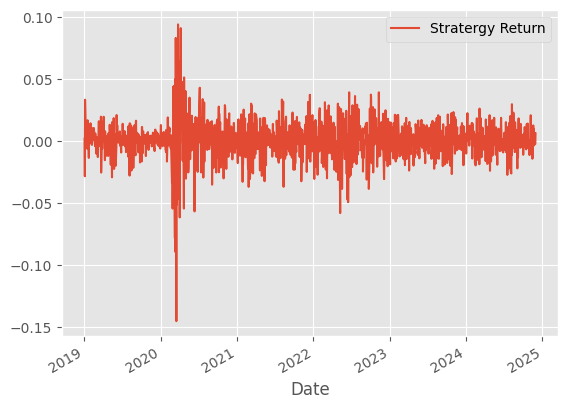

In [137]:
portfolio_df.plot()

### Calculates weights of stocks in our portfolio

In [ ]:
"""
weights = optimise_weights(prices=optimisation_df,
                           lower_bound=round(1/(len(optimisation_df.columns)*2), 4))

weights = pd.DataFrame(weights, index=pd.Series(0))

temp_df = returns_dataframe['2019-01-01':'2019-01-31']

temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
    .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
          left_index=True,
          right_index=True)\
    .reset_index().set_index(['Date', 'Ticker'])
"""

### Visualise Portfolio returns and compare to SP500 returns

In [172]:
# spy = yf.download(tickers='SPY',
#                   start='2017-01-01',
#                   end=dt.date.today())

# spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis =1)

# spy_ret = spy_ret.xs('SPY Buy&Hold', axis=1, level=0)

# spy_ret.columns = ['SPY Buy&Hold']

# portfolio_df = portfolio_df.merge(spy_ret,
#                                left_index=True,
#                                right_index=True)

# portfolio_df = portfolio_df.rename_axis(None)

# portfolio_df

,Stratergy Return,SPY Buy&Hold
2019-01-02,0.002025,0.001040
2019-01-03,-0.028385,-0.024152
2019-01-04,0.033405,0.032947
2019-01-07,0.010269,0.007854
2019-01-08,0.003427,0.009352
...,...,...
2024-11-22,0.001828,0.003095
2024-11-25,0.001342,0.003386
2024-11-26,0.006543,0.005208
2024-11-27,-0.002547,-0.003035


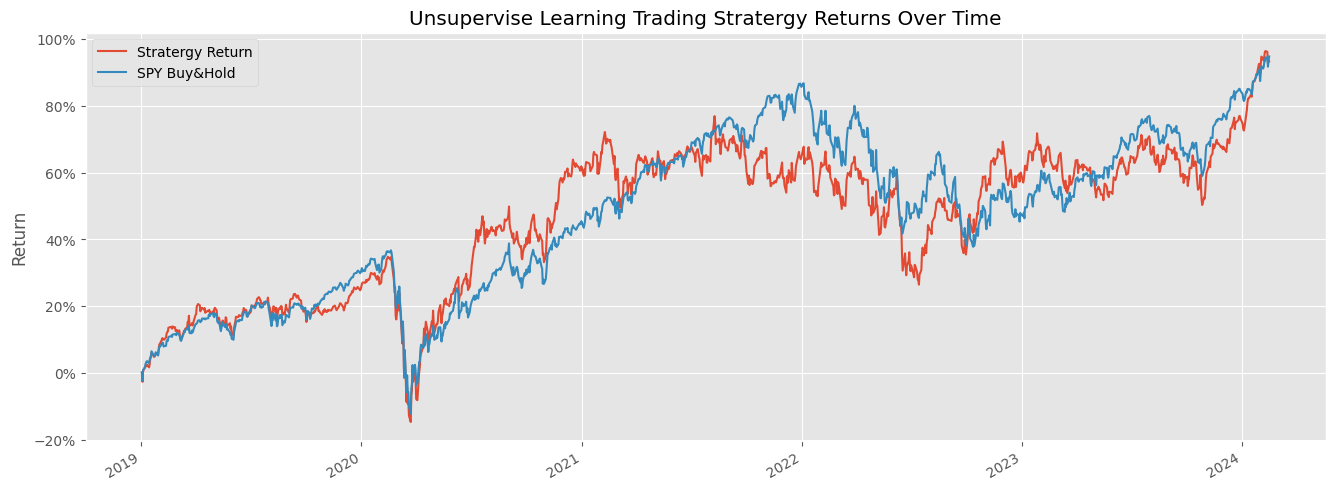

In [183]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_culmulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_culmulative_return[:'2024-02-15'].plot(figsize=(16,6))

plt.title('Unsupervise Learning Trading Stratergy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()